In [27]:
#basics
import numpy as np
import pandas as pd

#viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind')

#nlp
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from wordcloud import WordCloud

#modules
import prepare as prep

### Acquire and Prep
- use prep function on existing json file
- split the data

In [2]:
#acquire & prep
df = prep.prep_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 1 to 475
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   repo      353 non-null    object
 1   language  353 non-null    object
 2   content   353 non-null    object
dtypes: object(3)
memory usage: 11.0+ KB


##### Split the data

In [4]:
tr, val, te = prep.split_data(df)

In [5]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 115 to 153
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   repo      197 non-null    object
 1   language  197 non-null    object
 2   content   197 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


### Exploration

##### Target Variable Distribution

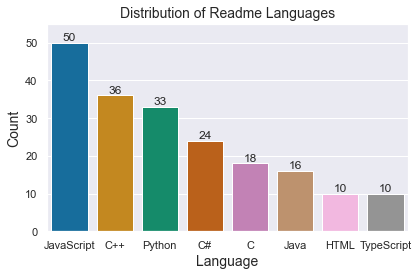

In [6]:
ax = sns.countplot(data=tr,x='language',order=tr.language.value_counts().index); 
#show count
for bar in ax.patches:
    #calculate middle x of bar
    x_pt = bar.get_x() + (bar.get_width() / 2)
    #Add small buffer to height of bar (y)
    y_pt = bar.get_height() + .5
    #plot values - note that the height in this case is the value we want to plot
    ax.text(x = x_pt, y = y_pt, s = bar.get_height(),horizontalalignment='center')

plt.title('Distribution of Readme Languages',size=14)
plt.ylabel('Count',size=14)
plt.xlabel('Language',size=14)
plt.ylim((0,55))
plt.tight_layout()

In [7]:
#as a function
def plot_target_distro(tr):
    '''
    Plots the distribution of the target variable (language)
    '''
    ax = sns.countplot(data=tr,x='language',order=tr.language.value_counts().index); 
    #show count
    for bar in ax.patches:
        #calculate middle x of bar
        x_pt = bar.get_x() + (bar.get_width() / 2)
        #Add small buffer to height of bar (y)
        y_pt = bar.get_height() + .5
        #plot values - note that the height in this case is the value we want to plot
        ax.text(x = x_pt, y = y_pt, s = bar.get_height(),horizontalalignment='center')

    plt.title('Distribution of Readme Languages',size=14)
    plt.ylabel('Count',size=14)
    plt.xlabel('Language',size=14)
    plt.ylim((0,55))
    plt.tight_layout()
    return None

##### Look at TF and TF-IDF for tes

In [8]:
#aggregate readme contents by language
all_text = ' '.join(tr.content)
javascripttxt = ' '.join(tr[tr.language == 'JavaScript'].content)
pythontxt = ' '.join(tr[tr.language == 'Python'].content)
cplustxt = ' '.join(tr[tr.language == 'C++'].content)
csharptxt = ' '.join(tr[tr.language == 'C#'].content)
ctxt = ' '.join(tr[tr.language == 'C'].content)
javatxt = ' '.join(tr[tr.language == 'Java'].content)
htmltxt = ' '.join(tr[tr.language == 'HTML'].content)
tstxt = ' '.join(tr[tr.language == 'TypeScript'].content)

In [9]:
#create word lists and get value counts for each
all_freq = pd.Series(str(all_text).split()).value_counts()
javascr_freq = pd.Series(str(javascripttxt).split()).value_counts()
python_freq = pd.Series(str(pythontxt).split()).value_counts()
cplus_freq = pd.Series(str(cplustxt).split()).value_counts()
csharp_freq = pd.Series(str(csharptxt).split()).value_counts()
c_freq = pd.Series(str(ctxt).split()).value_counts()
java_freq = pd.Series(str(javatxt).split()).value_counts()
html_freq = pd.Series(str(htmltxt).split()).value_counts()
ts_freq = pd.Series(str(tstxt).split()).value_counts()

In [10]:
#combine into one dataframe
freq_list = [all_freq, javascr_freq, python_freq, cplus_freq, csharp_freq,
             c_freq, java_freq, html_freq, ts_freq]
name_list = ['all','JavaScript','Python','C++','C#','C','Java','HTML','TypeScript']

word_counts = (pd.concat(freq_list,axis=1, sort=True)
                .set_axis(name_list, axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [11]:
word_counts.sort_values(by='JavaScript').tail(10)

,all,JavaScript,Python,C++,C#,C,Java,HTML,TypeScript
1,246,56,48,51,35,9,5,5,37
file,354,67,68,110,58,29,8,1,13
fix,123,69,4,6,40,2,0,0,2
use,426,74,107,80,93,18,24,2,28
npm,99,79,0,0,0,0,0,0,20
method,206,85,23,52,26,0,13,0,7
run,281,88,61,33,35,14,10,3,37
install,325,90,115,55,23,13,3,2,24
add,250,126,18,19,55,9,13,1,9
class,236,132,9,61,19,0,12,2,1


In [12]:
#create groupby for content
grouped = pd.DataFrame(tr.groupby(by='language')['content'].transform(lambda x: ' '.join(x)).drop_duplicates())
#get names for the indices
names = [tr.loc[115,'language'], tr.loc[395,'language'],
         tr.loc[166,'language'], tr.loc[348,'language'],
         tr.loc[124,'language'], tr.loc[248,'language'],
         tr.loc[385,'language'], tr.loc[19,'language']]

#set axis labels
grouped.set_axis(names,inplace=True)

In [13]:
grouped

,content
C++,img srchttpsrawgithubusercontentcomgameplay3dg...
HTML,welcome github project based learning activity...
C#,p aligncenter img srchttpsuserimagesgithubuser...
C,break arcade breakout arcade people could mak...
JavaScript,slack poker bot build status bot turn slack le...
Java,gameshardingdb springshardingmybaitsredis spri...
Python,open source please visit web page render conte...
TypeScript,heroic launcher discord github release github ...


In [14]:
#Now we can use vectorizer on aggregated columns
tfidf = TfidfVectorizer() #initialize vectorizer
tfidfs = tfidf.fit_transform(grouped.content) #create sparse matrix
tr_tfidf = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names()) #convert to DataFrame
tr_tfidf.set_index(grouped.index, inplace=True)

In [15]:
tr_tfidf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, C++ to TypeScript
Columns: 13429 entries, 00 to zypper
dtypes: float64(13429)
memory usage: 839.4+ KB


In [16]:
tr_tfidf.head()

,00,0000001,00003,0001,001,0016666,00alternatelanguages,00f,01,0100,...,zookeeper,zoorlcardmodels,zork,zot,zracer,ztrack,zulko,zweif,zyliu28mailustceducnmailtozyliu28mailustceducn,zypper
C++,0.00815,0.0,0.0,0.000000,0.0,0.004863,0.0000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.004863,0.004075
HTML,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.0,0.0,0.007270,0.004337,0.004337,0.004337,0.0,0.0,0.000000,0.000000
C#,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0039,0.007799,0.003268,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
C,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
JavaScript,0.00000,0.0,0.0,0.004486,0.0,0.000000,0.0000,0.000000,0.000000,0.004486,...,0.0,0.0,0.015039,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [17]:
tr_tfidf.sort_values(by='C',axis=1,ascending=False).loc['C',:].head(10)

header        0.320801
xwindow       0.300075
text          0.186364
version       0.177147
cc            0.169836
skynx         0.169608
available     0.161516
file          0.151096
build         0.145597
gtkradiant    0.117421
Name: C, dtype: float64

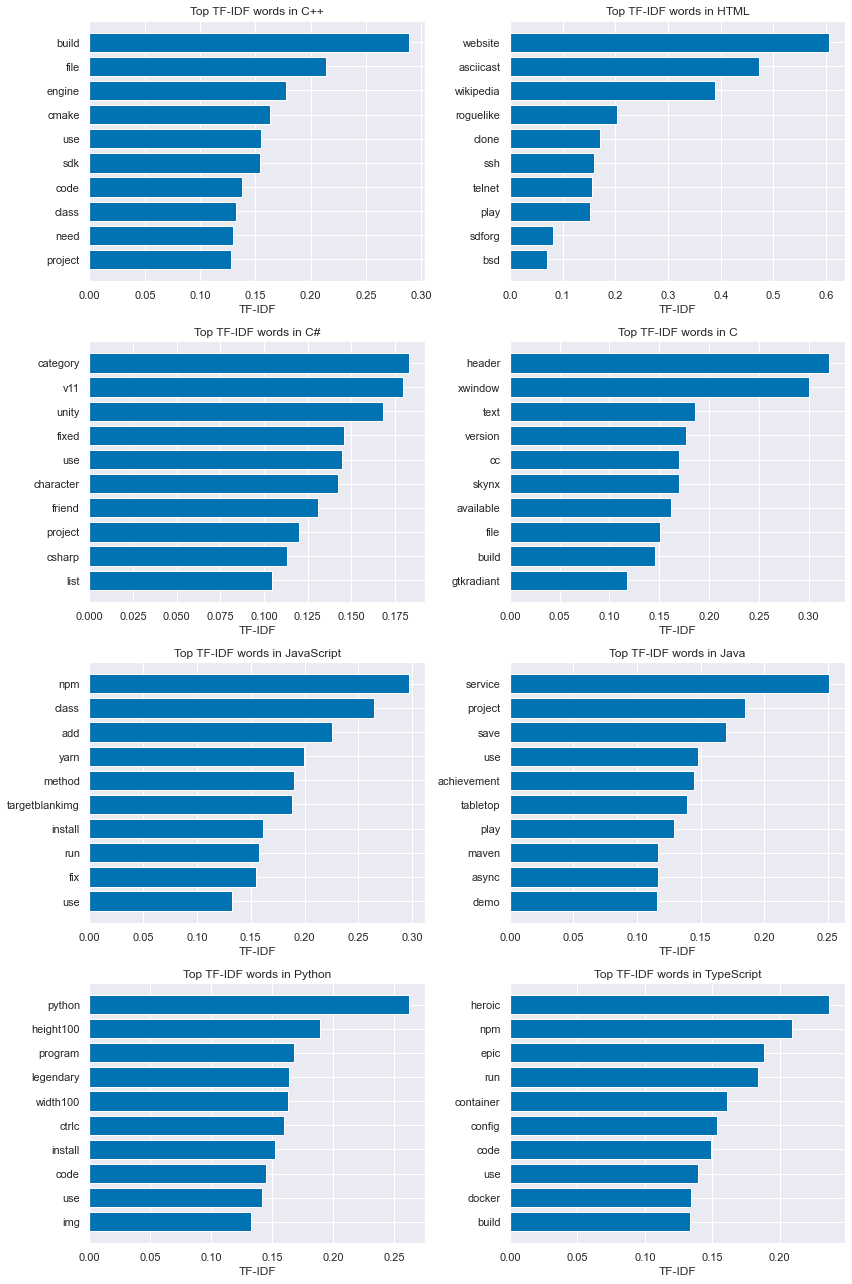

In [21]:
plt.figure(figsize=(12,18))
for cnt,l in enumerate(tr_tfidf.index):
    #sort by language, grab top 10 - series index is name
    top10 = tr_tfidf.sort_values(by=l,axis=1,ascending=False).loc[l,:].head(10)
    
    plt.subplot(4,2,cnt+1)
    #graph first 10 columns
    plt.barh(y=top10.index,width=top10);
    plt.title(f'Top TF-IDF words in {l}');
    plt.xlabel(f'TF-IDF');
    plt.gca().invert_yaxis()

plt.tight_layout()

In [19]:
#Create function 
def create_aggregated_tfidf(train):
    '''
    Creates a TF-IDF score for each word by language. 
    Languages are aggregated into a single 'document'
    
    Returns: Pandas DataFrame (columns are words, index is language, cell is tf-idf score for that word/language)
    '''
    #GROUP content by language
    grouped = pd.DataFrame(tr.groupby(by='language')['content'].transform(lambda x: ' '.join(x)).drop_duplicates())
    #get names for the indices
    names = [tr.loc[115,'language'], tr.loc[395,'language'],
             tr.loc[166,'language'], tr.loc[348,'language'],
             tr.loc[124,'language'], tr.loc[248,'language'],
             tr.loc[385,'language'], tr.loc[19,'language']]
    #set index labels
    grouped.set_axis(names,inplace=True)
    
    #CREATE TF-IDF Vectorizer for grouped content
    #initialize vectorizer
    tfidf = TfidfVectorizer() 
    #create sparse matrix
    tfidfs = tfidf.fit_transform(grouped.content) 
    #convert to DataFrame
    tr_tfidf = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names()) 
    #Set human friendly index names
    tr_tfidf.set_index(grouped.index, inplace=True)
    return tr_tfidf

In [20]:
create_aggregated_tfidf(tr)

,00,0000001,00003,0001,001,0016666,00alternatelanguages,00f,01,0100,...,zookeeper,zoorlcardmodels,zork,zot,zracer,ztrack,zulko,zweif,zyliu28mailustceducnmailtozyliu28mailustceducn,zypper
C++,0.00815,0.000000,0.000000,0.000000,0.000000,0.004863,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004863,0.004075
HTML,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.007270,0.004337,0.004337,0.004337,0.000000,0.000000,0.000000,0.000000
C#,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0039,0.007799,0.003268,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JavaScript,0.00000,0.000000,0.000000,0.004486,0.000000,0.000000,0.0000,0.000000,0.000000,0.004486,...,0.000000,0.000000,0.015039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Java,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.030887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Python,0.00557,0.003323,0.003323,0.000000,0.006646,0.000000,0.0000,0.000000,0.005570,0.000000,...,0.000000,0.003323,0.000000,0.000000,0.000000,0.000000,0.009969,0.003323,0.000000,0.011140
TypeScript,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


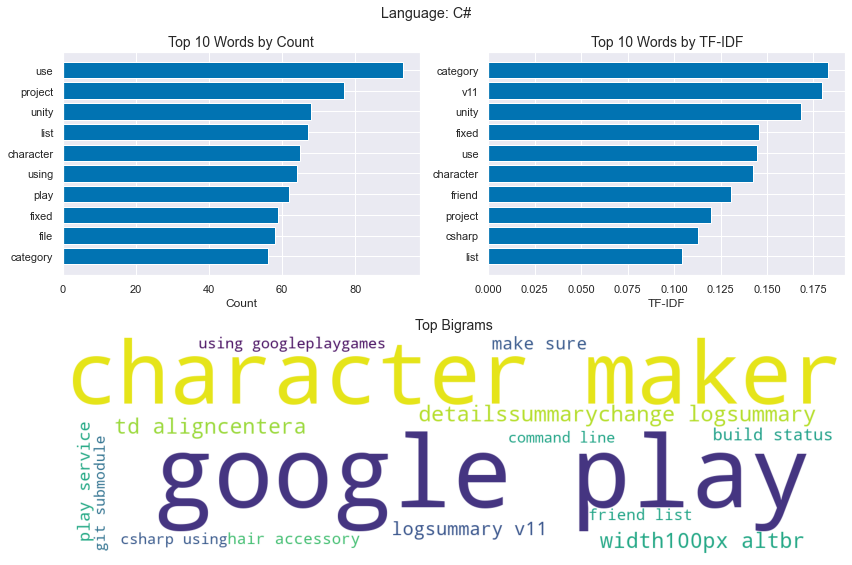

In [37]:
#Create a function that takes a language, train and tfidf_df:
# plots the top 10 words, top 10 tf-idf words and a bigram word cloud
langs = ['Python','C#','JavaScript']

lang = 'C#'
#get top 10 tf-idf
top10 = tr_tfidf.sort_values(by=lang,axis=1,ascending=False).loc[lang,:].head(10)
#get top 10 words
txt = ' '.join(tr[tr.language == lang].content)
freq = pd.Series(str(txt).split()).value_counts().head(10)

#get bigrams
bigrams = pd.Series(nltk.ngrams(txt.split(), 2)).value_counts().head(15)

#
plt.figure(figsize=(12,8))
plt.suptitle(f'Language: {lang}')

#First plot - Top Left - top 10 words
plt.subplot(2,2,1)
plt.barh(y=freq.index,width=freq);
plt.title(f'Top 10 Words by Count',size=14);
plt.xlabel(f'Count');
plt.gca().invert_yaxis();

#Second plot - Top Right - top 10 tf-idf words
plt.subplot(2,2,2)
plt.barh(y=top10.index,width=top10);
plt.title(f'Top 10 Words by TF-IDF',size=14);
plt.xlabel(f'TF-IDF');
plt.gca().invert_yaxis();


#Third plot - Bottom - Bigram word cloud
plt.subplot(2,2,(3,4))
data = {k[0] + ' ' + k[1]: v for k, v in bigrams.to_dict().items()}
bigramc = WordCloud(background_color='white', width=1400, height=400).generate_from_frequencies(data)
plt.imshow(bigramc)
plt.title('Top Bigrams',size=14)
plt.axis('off')

plt.tight_layout()

In [ ]:

def generate_plots_and_cloud(lang,tr,tr_tfidf):
    '''
    Generates plots and bigram word cloud for a given language. 
    Parameters:
        (R) lang: the language to plot (string must exactly match what the github readme api produces)
        (R)   tr: train dataframe
    (R) tr_tfidf: DataFrame of tf-idf values.  Created using 'create_aggregated_tfidf' function
    '''
    #GET DATA SUBSETS
    #get top 10 tf-idf
    top10 = tr_tfidf.sort_values(by=lang,axis=1,ascending=False).loc[lang,:].head(10)
    #get top 10 words
    txt = ' '.join(tr[tr.language == lang].content)
    freq = pd.Series(str(txt).split()).value_counts().head(10)
    #get bigrams
    bigrams = pd.Series(nltk.ngrams(txt.split(), 2)).value_counts().head(15)

    #INITIALIZE FIGURE
    plt.figure(figsize=(12,8))
    plt.suptitle(f'Language: {lang}')

    #FIRST PLOT - Top Left - top 10 words
    plt.subplot(2,2,1)
    plt.barh(y=freq.index,width=freq);
    plt.title(f'Top 10 Words by Count',size=14);
    plt.xlabel(f'Count');
    plt.gca().invert_yaxis();

    #SECOND PLOT - Top Right - top 10 tf-idf words
    plt.subplot(2,2,2)
    plt.barh(y=top10.index,width=top10);
    plt.title(f'Top 10 Words by TF-IDF',size=14);
    plt.xlabel(f'TF-IDF');
    plt.gca().invert_yaxis();


    #THIRD PLOT - Bottom - Bigram word cloud
    plt.subplot(2,2,(3,4))
    data = {k[0] + ' ' + k[1]: v for k, v in bigrams.to_dict().items()}
    bigramc = WordCloud(background_color='white', width=1400, height=400).generate_from_frequencies(data)
    plt.imshow(bigramc)
    plt.title('Top Bigrams',size=14)
    plt.axis('off')

    plt.tight_layout()
    
    return None